In [1]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyproj import Proj, transform
import contextily as ctx
import geopandas as gpd
from shapely.geometry import box, Point
import warnings
warnings.filterwarnings('ignore')

In [2]:
accidents = pd.read_csv("LondonAccidents2023.csv")

In [3]:
accidents.columns

Index(['_Collision Id', '_Collision Date', 'Borough Name', 'Borough Number',
       'Easting', 'Northing', '_Vehicle Id', 'Vehicle Type Banded',
       'Vehicle Type', 'Vehicle Manoeuvres',
       'Vehicle Skidding and Overturning', 'Vehicle Restricted Lane',
       'Location of Vehicle at First Impact',
       'Vehicle Hit Object in Carriageway', 'Vehicle Leaving Carriageway',
       'Vehicle Hit Object Off Carriageway', 'First Point of Impact',
       'Journey Purpose', 'Driver Gender', 'Driver Age',
       'Driver age (Banded)'],
      dtype='object')

In [9]:
accidents.loc[:, "_Collision Id"].size

31072

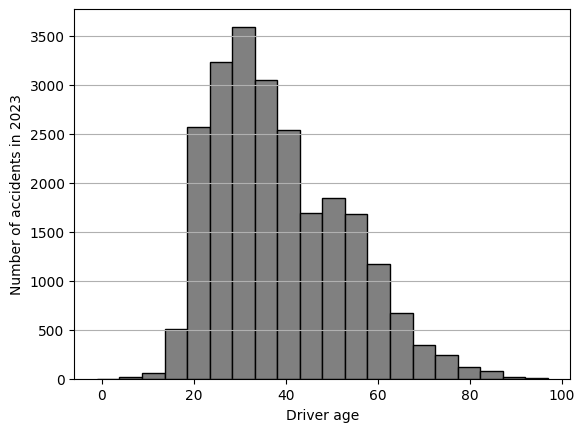

In [14]:
plt.hist(accidents.loc[:, "Driver Age"], bins = 20, color = "grey", edgecolor = "black")
plt.xlabel("Driver age", fontsize = 10)
plt.grid(axis = "y")
plt.ylabel("Number of accidents in 2023", fontsize = 10)
plt.show()

In [38]:
print(max(accidents.loc[:, "Northing"]))
print(min(accidents.loc[:, "Northing"]))
print(max(accidents.loc[:, "Easting"]))
print(min(accidents.loc[:, "Easting"]))

200729
157022
559232
503824


In [4]:
bng = Proj(init='epsg:27700')
wgs84 = Proj(init='epsg:4326')
lon, lat = transform(bng, wgs84, accidents.loc[:, "Easting"].tolist(), accidents.loc[:, "Northing"].tolist())

In [57]:
print(min(lon))
print(max(lon))
print(min(lat))
print(max(lat))

-0.5066091378034554
0.29482882479207145
51.29709306959845
51.690067959000196


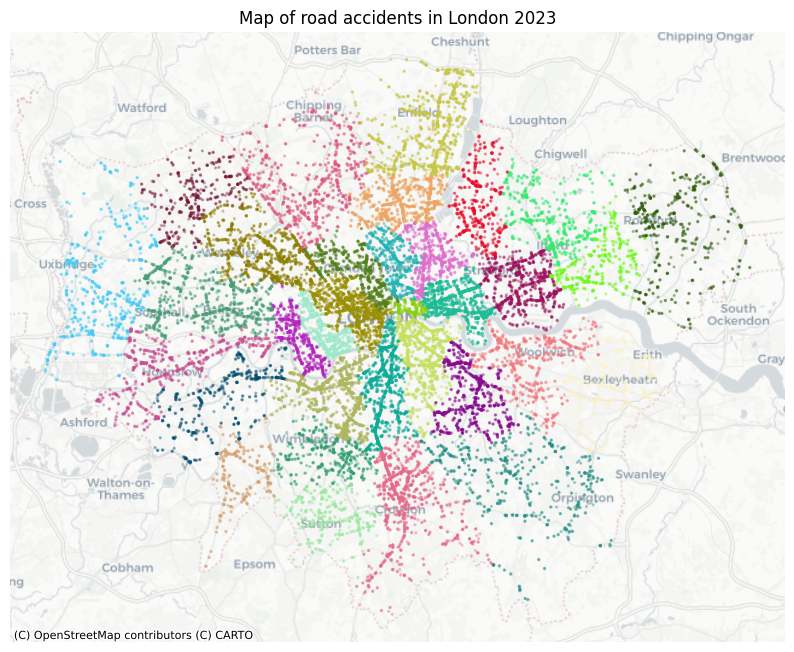

In [13]:
london_bbox = gpd.GeoDataFrame(geometry=[box(min(lon), min(lat), max(lon), max(lat))], crs = "EPSG:4326")
london_bbox = london_bbox.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 10))

london_bbox.boundary.plot(ax=ax, alpha=0)

accident_points = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in zip(lon, lat)], crs = "EPSG:4326")
accident_points = accident_points.to_crs(epsg=3857)

places = accidents.loc[:, "Borough Name"].unique()

np.random.seed(1234)
colors = np.random.rand(len(places), 3)
color_map = dict(zip(places, colors))
coloring = accidents.loc[:, "Borough Name"].map(color_map)
accident_points.plot(ax=ax, color=coloring, alpha=0.3, markersize=2)

ctx.add_basemap(ax, crs=london_bbox.crs.to_string(), source=ctx.providers.CartoDB.Positron, alpha = 1)

ax.set_title('Map of road accidents in London 2023')
ax.set_axis_off()
plt.savefig("LondonAccidents.png", transparent = True, dpi = 1000)
plt.show()

In [17]:
df = accidents.loc[:, ["_Collision Date", "Easting"]]
df = df.groupby("_Collision Date").agg(NumberOfAccidents = ("Easting", "size")).reset_index()
df["_Collision Date"] = pd.to_datetime(df["_Collision Date"], format = "%d/%m/%Y %H:%M").dt.strftime("%Y-%m-%d")

In [33]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.5085,
	"longitude": -0.1257,
	"start_date": "2023-01-01",
	"end_date": "2023-09-30",
	"daily": "temperature_2m_mean",
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

temp = responses[0].Daily().Variables(0).ValuesAsNumpy()
temp = pd.DataFrame(temp)
temp["date"] = pd.date_range(start = "2023-01-01", end = "2023-09-30")
temp["temperature"] = temp.loc[:, 0]
temp = temp.drop(columns = [0])
temp["date"] = temp["date"].astype(object)
temp["date"] = pd.to_datetime(temp["date"]).dt.strftime("%Y-%m-%d")

In [37]:
weatherAccidents = pd.merge(df, temp, left_on = "_Collision Date", right_on = "date")

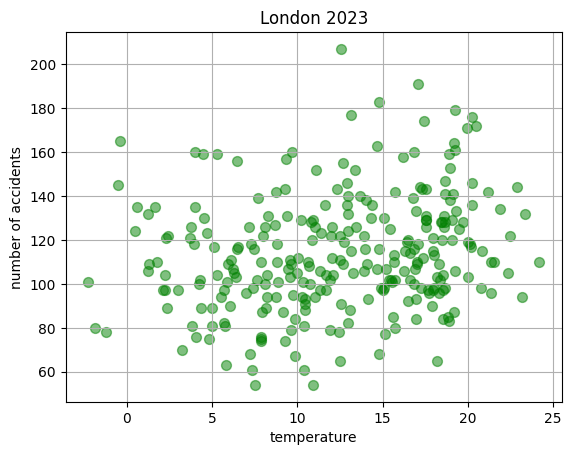

In [38]:
plt.scatter(weatherAccidents["temperature"], weatherAccidents["NumberOfAccidents"], c = "green", s = 50, alpha = 0.5)
plt.grid(True)
plt.ylabel("number of accidents")
plt.xlabel("temperature")
plt.title("London 2023")
plt.show()

In [44]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.5085,
	"longitude": -0.1257,
	"start_date": "2023-01-01",
	"end_date": "2023-09-30",
	"daily": "precipitation_sum",
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

prec = responses[0].Daily().Variables(0).ValuesAsNumpy()

prec = pd.DataFrame(prec)
prec["date"] = pd.date_range(start = "2023-01-01", end = "2023-09-30")
prec["prec"] = prec.loc[:, 0]
prec = prec.drop(columns = [0])
prec["date"] = prec["date"].astype(object)
prec["date"] = pd.to_datetime(prec["date"]).dt.strftime("%Y-%m-%d")

weatherAccidents = pd.merge(df, prec, left_on = "_Collision Date", right_on = "date")

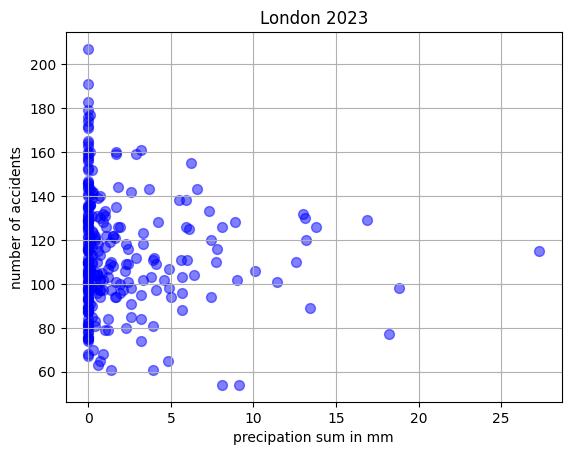

In [45]:
plt.scatter(weatherAccidents["prec"], weatherAccidents["NumberOfAccidents"], c = "blue", s = 50, alpha = 0.5)
plt.grid(True)
plt.ylabel("number of accidents")
plt.xlabel("precipation sum in mm")
plt.title("London 2023")
plt.show()

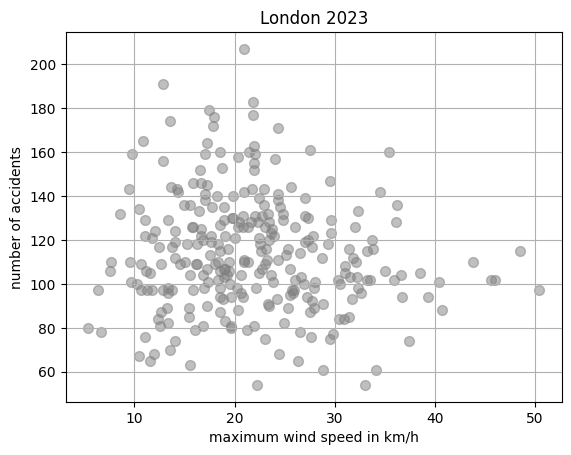

In [57]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.5085,
	"longitude": -0.1257,
	"start_date": "2023-01-01",
	"end_date": "2023-09-30",
	"daily": "wind_speed_10m_max",
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

wind = responses[0].Daily().Variables(0).ValuesAsNumpy()

wind = pd.DataFrame(wind)
wind["date"] = pd.date_range(start = "2023-01-01", end = "2023-09-30")
wind["wind"] = wind.loc[:, 0]
wind = wind.drop(columns = [0])
wind["date"] = wind["date"].astype(object)
wind["date"] = pd.to_datetime(wind["date"]).dt.strftime("%Y-%m-%d")

weatherAccidents = pd.merge(df, wind, left_on = "_Collision Date", right_on = "date")

plt.scatter(weatherAccidents["wind"], weatherAccidents["NumberOfAccidents"], c = "grey", s = 50, alpha = 0.5)
plt.grid(True)
plt.ylabel("number of accidents")
plt.xlabel("maximum wind speed in km/h")
plt.title("London 2023")
plt.show()

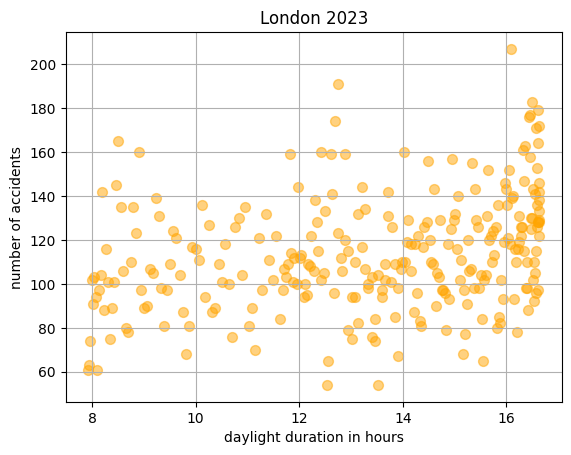

In [60]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.5085,
	"longitude": -0.1257,
	"start_date": "2023-01-01",
	"end_date": "2023-09-30",
	"daily": "daylight_duration",
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

day = responses[0].Daily().Variables(0).ValuesAsNumpy()

day = pd.DataFrame(day)
day["date"] = pd.date_range(start = "2023-01-01", end = "2023-09-30")
day["day"] = day.loc[:, 0]
day = day.drop(columns = [0])
day["date"] = day["date"].astype(object)
day["date"] = pd.to_datetime(day["date"]).dt.strftime("%Y-%m-%d")

weatherAccidents = pd.merge(df, day, left_on = "_Collision Date", right_on = "date")

plt.scatter(weatherAccidents["day"]/(60*60), weatherAccidents["NumberOfAccidents"], c = "orange", s = 50, alpha = 0.5)
plt.grid(True)
plt.ylabel("number of accidents")
plt.xlabel("daylight duration in hours")
plt.title("London 2023")
plt.show()

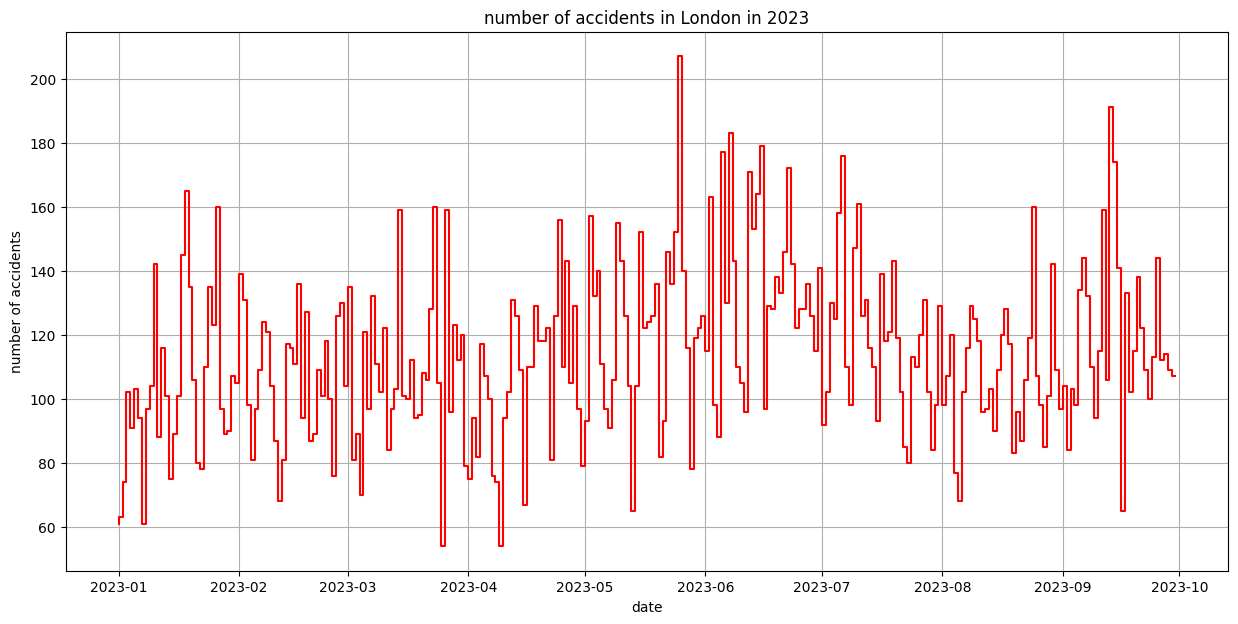

In [141]:
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(df, color = "red", drawstyle = "steps")
ax.grid(True)
ax.set_ylabel("number of accidents")
ax.set_xlabel("date")
ax.set_title("number of accidents in London in 2023")
plt.show()

In [25]:
df = accidents.loc[:, ["_Collision Date", "Easting"]]
df["date"] = pd.to_datetime(df["_Collision Date"], format = "%d/%m/%Y %H:%M").dt.strftime("%Y-%m")

In [30]:
df_month = df.groupby("date").agg(num = ("Easting", "size"), date = ("date", "first")).reset_index(drop = True)

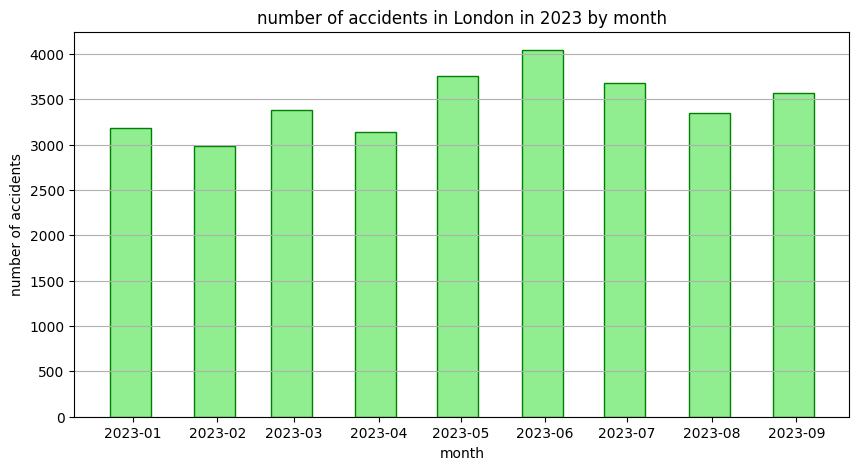

In [32]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.bar(pd.date_range(start='2022-12-01', end='2023-09-01', freq='M'), df_month.loc[:, "num"], width = 15, color = "lightgreen", edgecolor = "green")
ax.set_ylabel("number of accidents")
ax.set_xlabel("month")
ax.set_title("number of accidents in London in 2023 by month")
ax.grid(axis = "y")
plt.show()

In [6]:
accidents.loc[:, "Vehicle Type"].unique()

array(['London Bus', 'Car', 'Pedal Cycle', 'M/C 50-125CC', 'Taxi',
       'M/C <= 50CC', 'M/C 125-500CC', 'Goods Unknown kg (S/R)',
       'M/C > 500CC', 'GDS =< 3.5T', 'Other Vehicle', 'Minibus',
       'Private Hire - Licensed', 'GDS => 7.5T', 'Bus/Coach',
       'M/C Electric', 'Mobility Scooter', 'M/C Unknown CC (S/R)',
       'GDS 3.5-7.5T', 'Agric Veh', 'Tram', 'Rickshaw', 'Ridden Horse',
       'Private Hire - Unlicensed'], dtype=object)

In [33]:
type = accidents.loc[:, ("_Collision Date", "Vehicle Type")]

In [34]:
include_types = ['London Bus', 'Car', 'Pedal Cycle', 'M/C 50-125CC', 'Taxi',
       'M/C <= 50CC', 'M/C 125-500CC',
       'M/C > 500CC', 'GDS =< 3.5T', 'Minibus',
       'Private Hire - Licensed', 'GDS => 7.5T', 'Bus/Coach',
       'M/C Electric', 'GDS =< 3.5T', 'Minibus', 
       'GDS 3.5-7.5T']
motorcycles = ['M/C <= 50CC', 'M/C 125-500CC', 'M/C > 500CC', 'M/C 50-125CC', 'M/C Electric']
buses = ['London Bus', 'GDS =< 3.5T', 'Minibus', 'GDS => 7.5T', 'Bus/Coach', 'GDS 3.5-7.5T']
taxi = ['Taxi', 'Private Hire - Licensed']
type_count = type[type["Vehicle Type"].isin(include_types)]["Vehicle Type"]
type_count = type_count.apply(lambda x: 'Motorcycle' if x in motorcycles else x)
type_count = type_count.apply(lambda x: 'Bus' if x in buses else x)
type_count = type_count.apply(lambda x: 'Taxi' if x in taxi else x)
type_count = type_count.value_counts()
type_count["Other"] = len(type) - type_count.sum()

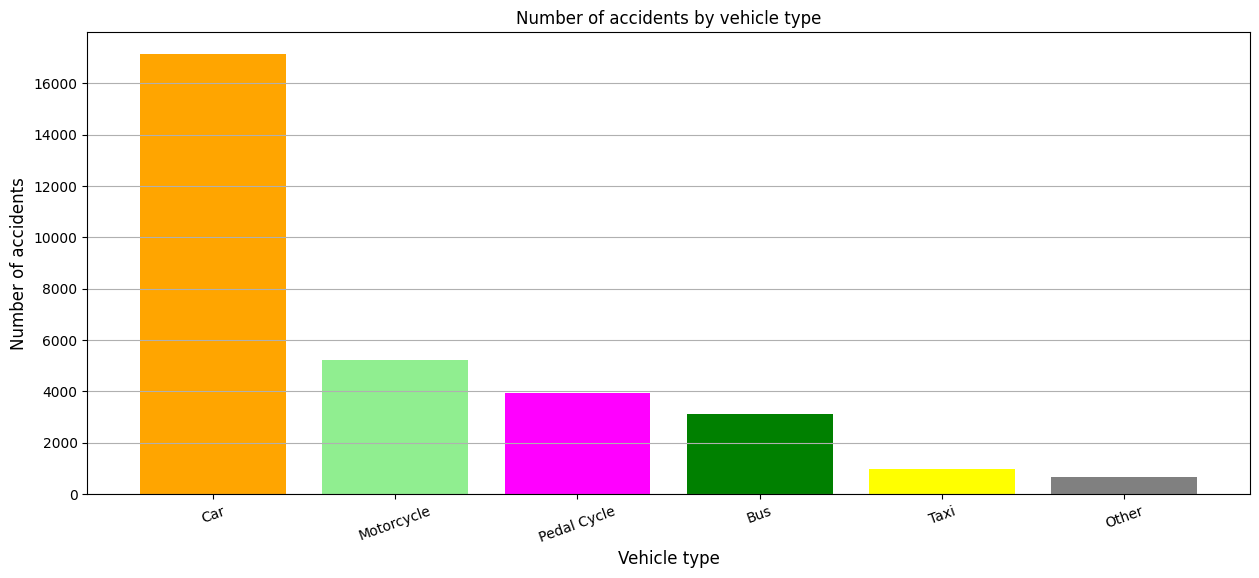

In [36]:
fig, ax = plt.subplots(figsize = (15, 6))
ax.bar(type_count.index, type_count.values, color = ["orange", "lightgreen", "magenta", "green", "yellow", "gray"])
ax.set_xlabel("Vehicle type", fontsize = 12)
ax.set_ylabel("Number of accidents", fontsize = 12)
ax.set_title("Number of accidents by vehicle type")
ax.tick_params(axis = "x", rotation = 20)
ax.grid(axis = "y")
plt.show()

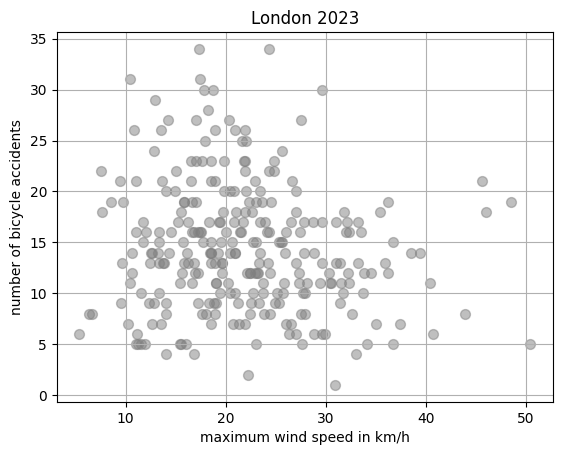

In [62]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.5085,
	"longitude": -0.1257,
	"start_date": "2023-01-01",
	"end_date": "2023-09-30",
	"daily": "wind_speed_10m_max",
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

wind = responses[0].Daily().Variables(0).ValuesAsNumpy()

wind = pd.DataFrame(wind)
wind["date"] = pd.date_range(start = "2023-01-01", end = "2023-09-30")
wind["wind"] = wind.loc[:, 0]
wind = wind.drop(columns = [0])
wind["date"] = wind["date"].astype(object)
wind["date"] = pd.to_datetime(wind["date"]).dt.strftime("%Y-%m-%d")

df = accidents.loc[accidents["Vehicle Type"] == "Pedal Cycle", ["_Collision Date", "Easting"]]
df = df.groupby("_Collision Date").agg(NumberOfAccidents = ("Easting", "size")).reset_index()
df["_Collision Date"] = pd.to_datetime(df["_Collision Date"], format = "%d/%m/%Y %H:%M").dt.strftime("%Y-%m-%d")

weatherAccidents = pd.merge(df, wind, left_on = "_Collision Date", right_on = "date")

plt.scatter(weatherAccidents["wind"], weatherAccidents["NumberOfAccidents"], c = "grey", s = 50, alpha = 0.5)
plt.grid(True)
plt.ylabel("number of bicycle accidents")
plt.xlabel("maximum wind speed in km/h")
plt.title("London 2023")
plt.show()

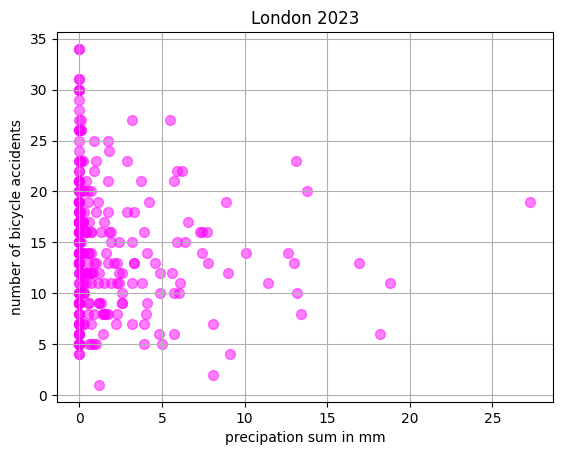

In [40]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.5085,
	"longitude": -0.1257,
	"start_date": "2023-01-01",
	"end_date": "2023-09-30",
	"daily": "precipitation_sum",
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

prec = responses[0].Daily().Variables(0).ValuesAsNumpy()

prec = pd.DataFrame(prec)
prec["date"] = pd.date_range(start = "2023-01-01", end = "2023-09-30")
prec["prec"] = prec.loc[:, 0]
prec = prec.drop(columns = [0])
prec["date"] = prec["date"].astype(object)
prec["date"] = pd.to_datetime(prec["date"]).dt.strftime("%Y-%m-%d")

df = accidents.loc[accidents["Vehicle Type"] == "Pedal Cycle", ["_Collision Date", "Easting"]]
df = df.groupby("_Collision Date").agg(NumberOfAccidents = ("Easting", "size")).reset_index()
df["_Collision Date"] = pd.to_datetime(df["_Collision Date"], format = "%d/%m/%Y %H:%M").dt.strftime("%Y-%m-%d")

weatherAccidents = pd.merge(df, prec, left_on = "_Collision Date", right_on = "date")

plt.scatter(weatherAccidents["prec"], weatherAccidents["NumberOfAccidents"], c = "magenta", s = 50, alpha = 0.5)
plt.grid(True)
plt.ylabel("number of bicycle accidents")
plt.xlabel("precipation sum in mm")
plt.title("London 2023")
plt.show()

In [4]:
df = accidents.loc[:, ("_Collision Date", "Vehicle Type")]
df["_Collision Date"] = pd.to_datetime(df["_Collision Date"], format = "%d/%m/%Y %H:%M")
df["Vehicle Type"] = df["Vehicle Type"].apply(lambda x: 'Other' if x != "Pedal Cycle" else x)
df = df.groupby(["_Collision Date", "Vehicle Type"])["Vehicle Type"].agg(NumberOfAccidents = "size").reset_index()

In [5]:
pvdf = df.pivot(index="_Collision Date", columns="Vehicle Type", values="NumberOfAccidents")
pvdf["fraction"] = (pvdf["Pedal Cycle"]/(pvdf["Other"] + pvdf["Pedal Cycle"])) * 100

In [6]:
fdf = pvdf.reset_index()

In [7]:
fdf["_Collision Date"] = pd.to_datetime(fdf["_Collision Date"]).dt.strftime("%Y-%m-%d")

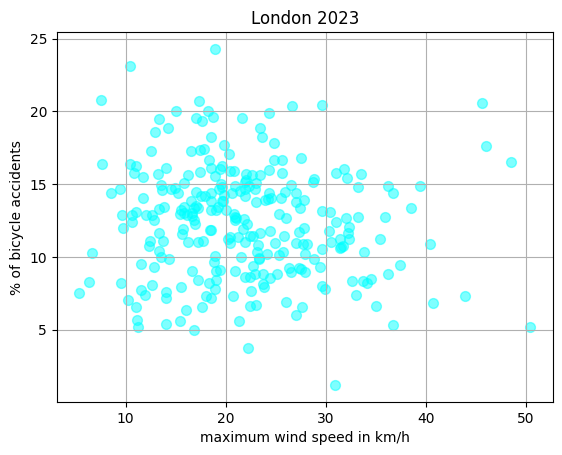

In [83]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.5085,
	"longitude": -0.1257,
	"start_date": "2023-01-01",
	"end_date": "2023-09-30",
	"daily": "wind_speed_10m_max",
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

wind = responses[0].Daily().Variables(0).ValuesAsNumpy()

wind = pd.DataFrame(wind)
wind["date"] = pd.date_range(start = "2023-01-01", end = "2023-09-30")
wind["wind"] = wind.loc[:, 0]
wind = wind.drop(columns = [0])
wind["date"] = wind["date"].astype(object)
wind["date"] = pd.to_datetime(wind["date"]).dt.strftime("%Y-%m-%d")

weatherAccidents = pd.merge(fdf, wind, left_on = "_Collision Date", right_on = "date")

plt.scatter(weatherAccidents["wind"], weatherAccidents["fraction"], c = "aqua", s = 50, alpha = 0.5)
plt.grid(True)
plt.ylabel("% of bicycle accidents")
plt.xlabel("maximum wind speed in km/h")
plt.title("London 2023")
plt.show()

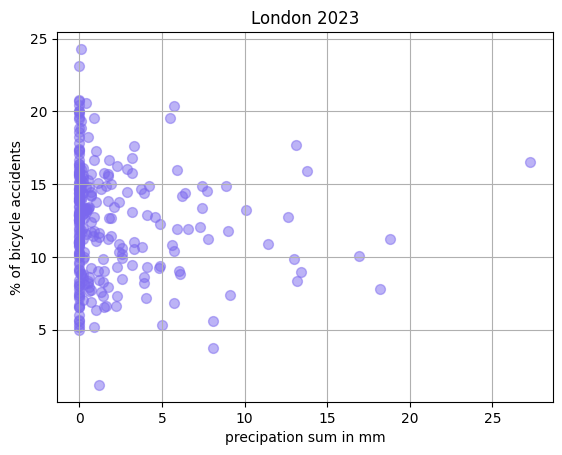

In [8]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.5085,
	"longitude": -0.1257,
	"start_date": "2023-01-01",
	"end_date": "2023-09-30",
	"daily": "precipitation_sum",
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

prec = responses[0].Daily().Variables(0).ValuesAsNumpy()

prec = pd.DataFrame(prec)
prec["date"] = pd.date_range(start = "2023-01-01", end = "2023-09-30")
prec["prec"] = prec.loc[:, 0]
prec = prec.drop(columns = [0])
prec["date"] = prec["date"].astype(object)
prec["date"] = pd.to_datetime(prec["date"]).dt.strftime("%Y-%m-%d")

weatherAccidents = pd.merge(fdf, prec, left_on = "_Collision Date", right_on = "date")

plt.scatter(weatherAccidents["prec"], weatherAccidents["fraction"], c = "mediumslateblue", s = 50, alpha = 0.5)
plt.grid(True)
plt.ylabel("% of bicycle accidents")
plt.xlabel("precipation sum in mm")
plt.title("London 2023")
plt.show()

In [9]:
accidents.columns

Index(['_Collision Id', '_Collision Date', 'Borough Name', 'Borough Number',
       'Easting', 'Northing', '_Vehicle Id', 'Vehicle Type Banded',
       'Vehicle Type', 'Vehicle Manoeuvres',
       'Vehicle Skidding and Overturning', 'Vehicle Restricted Lane',
       'Location of Vehicle at First Impact',
       'Vehicle Hit Object in Carriageway', 'Vehicle Leaving Carriageway',
       'Vehicle Hit Object Off Carriageway', 'First Point of Impact',
       'Journey Purpose', 'Driver Gender', 'Driver Age',
       'Driver age (Banded)'],
      dtype='object')

In [18]:
accidents.loc[:, "Location of Vehicle at First Impact"].unique()

array(['Leaving Main Rd', 'Jct App', "Leaving R'about",
       "Entering R'about", 'Entering Main Rd', 'Jct Mid', 'Not At Jct',
       'Jct Cleared', 'Unknown (S/R)', 'Entering From Slip'], dtype=object)

In [19]:
accidents.loc[:, "First Point of Impact"].unique()

array(['Front Hit First', 'N/S Hit First', 'O/S Hit First',
       'Back Hit First', 'Unknown (S/R)', 'Did Not Impact'], dtype=object)

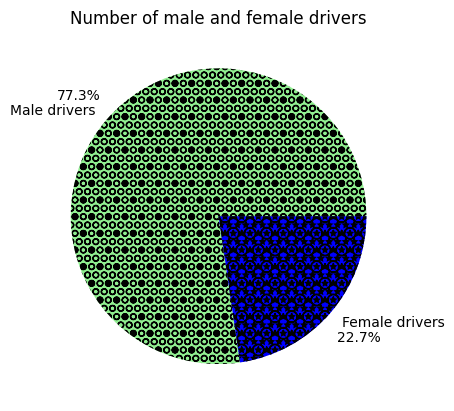

In [4]:
m = accidents.loc[accidents["Driver Gender"] == "Male", "Driver Gender"].size
f = accidents.loc[accidents["Driver Gender"] == "Female", "Driver Gender"].size
plt.pie([m, f], labels = ["Male drivers", "Female drivers"], hatch=['O.O', '**O'],
        colors = ["lightgreen", "blue"], autopct='%1.1f%%', pctdistance=1.25)
plt.title("Number of male and female drivers")
plt.show()

In [11]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.5085,
	"longitude": -0.1257,
	"start_date": "2023-01-01",
	"end_date": "2023-09-30",
	"hourly": "wind_direction_10m",
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

wind = responses[0].Hourly().Variables(0).ValuesAsNumpy()
wind = pd.DataFrame(wind).loc[:6528]
wind["date"] = pd.date_range(start = "2023-01-01", end = "2023-09-30", freq = "H")
wind["angle"] = wind.loc[:, 0]
wind = wind.drop(columns = [0])
wind["date"] = wind["date"].dt.strftime("%Y-%m-%d")
wind = wind.groupby("date").agg(date = ("date", "first"), angle = ("angle", "mean")).reset_index(drop = True)

In [12]:
df = accidents.loc[accidents["Vehicle Type"] == "Pedal Cycle", ["_Collision Date", "Easting"]].reset_index(drop = True)
df["date"] = pd.to_datetime(df["_Collision Date"], format = "%d/%m/%Y %H:%M").dt.strftime("%Y-%m-%d")
df = df.drop(columns = ["_Collision Date"])
df = df.groupby("date").agg(date = ("date", "first"), num = ("Easting", "size")).reset_index(drop = True)

In [13]:
wind_acc = pd.merge(df, wind, on = "date").reset_index(drop = True)
wind_acc["angle"] = (wind_acc["angle"]/360)*2*np.pi

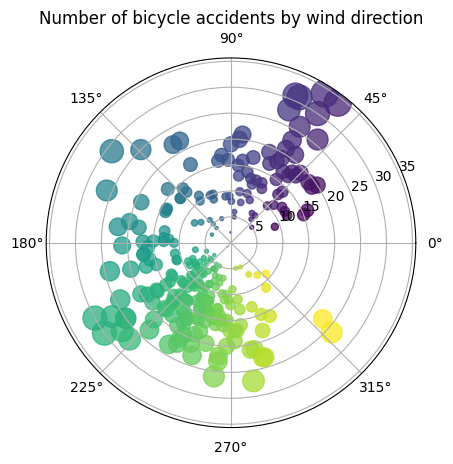

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.scatter(wind_acc["angle"], wind_acc["num"], c = wind_acc["angle"], alpha = 0.75, s = (wind_acc["num"]**2)/3)
ax.set_title("Number of bicycle accidents by wind direction")
plt.show()